In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
from collections import deque
import random

In [92]:
class NNpredictor():
    
    #init model and hyperparameters
    def __init__(self,input_shape,output_shape,env):
        self.env = env
        
        #models hyperparameters
        self.exploration_min = 0.01
        self.exploration_decay = 0.996
        self.exploration_rate = 1
        self.batch_size = 32
        self.gamma = 0.95
        self.lr = 0.001
        
        #model architecture
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_shape,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,output_shape),
        )
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        self.memory = deque(maxlen=1000000)
        
        
    #select an action, either random or from model
    def select_action(self,state):
        #this ensures that the model explores the environment and accumulates memory (stochasticity)
        if np.random.rand() < self.exploration_rate:
            return self.env.action_space.sample()
        
        state = torch.from_numpy(state.astype("float32")) 
        q_values = self.model(state)
        return torch.argmax(q_values).item()


    #add an experience to the model's memory
    def remember(self,last_state,action,reward,next_state,done):
        self.memory.append((last_state,action,reward,next_state,done))

        
    #replay experiences from memory and fit the model
    def experience_replay(self,logs,episode,episode_steps):

        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory,self.batch_size)

        running_loss = 0
        for last_state, action, reward, next_state, done in batch:
            q_update = reward
            if not done:
                #calculate what q value should have been for selected action
                q_update = (reward + self.gamma * torch.amax(self.model(torch.from_numpy(next_state.astype("float32")))).item())
            q_values = self.model(torch.from_numpy(last_state.astype("float32")))
            q_values[action] = q_update

            #fit
            l = self.loss(self.model(torch.from_numpy(last_state.astype("float32"))), q_values)
            self.model.zero_grad()
            l.backward()
            self.optimizer.step()
            running_loss += l.item()
        
        try:
            logs.episodes_loss[episode-1] += running_loss/self.batch_size
        except IndexError:
            logs.episodes_loss = np.append(logs.episodes_loss,running_loss/self.batch_size)

        #decay exploration rate to reduce randomness
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

In [93]:
class MetricsLogger():
    
    def __init__(self):
        self.episodes_steps = np.array([])
        self.episodes_before_solve = np.array([])
        self.episodes_loss = np.array([])

In [94]:
#Init environment
env = gym.make('CartPole-v0')
env._max_episode_steps = 200

#Init model
model = NNpredictor(4,2,env)

#Init Logger
logs = MetricsLogger()

In [95]:
################################
# Training loop #
################################
num_solved = 0
episode_i = 0
episode_i_before_solve = 0
while num_solved < 30 and episode_i < 500:
    episode_i += 1
    last_state = env.reset()
    steps = 0
    total_reward = 0
    episode_i_before_solve += 1
    
    while True:
        running_loss = 0
        #uncomment this to display simulation 
#         env.render()
        steps += 1
        action = model.select_action(last_state)
        next_state, reward, done, info = env.step(action)
        reward = reward if not done else -reward
        model.remember(last_state,action,reward,next_state,done)
        model.experience_replay(logs,episode_i,steps)
        
        total_reward += reward
        
        if done:
            print("Episode {} finished after {} steps with {} total reward".format(episode_i,steps,total_reward))
            if total_reward > 190:
                logs.episodes_before_solve = np.append(logs.episodes_before_solve,episode_i_before_solve)
                episode_i_before_solve = 0
                num_solved += 1
            break
    
        last_state = next_state
    
    logs.episodes_steps = np.append(logs.episodes_steps,steps)

print("Done")

env.close()

Episode 1 finished after 21 steps with 19.0 total reward
Episode 2 finished after 9 steps with 7.0 total reward
Episode 3 finished after 11 steps with 9.0 total reward
Episode 4 finished after 19 steps with 17.0 total reward
Episode 5 finished after 56 steps with 54.0 total reward
Episode 6 finished after 9 steps with 7.0 total reward
Episode 7 finished after 23 steps with 21.0 total reward
Episode 8 finished after 25 steps with 23.0 total reward
Episode 9 finished after 11 steps with 9.0 total reward
Episode 10 finished after 9 steps with 7.0 total reward
Episode 11 finished after 40 steps with 38.0 total reward
Episode 12 finished after 36 steps with 34.0 total reward
Episode 13 finished after 57 steps with 55.0 total reward
Episode 14 finished after 35 steps with 33.0 total reward
Episode 15 finished after 48 steps with 46.0 total reward
Episode 16 finished after 41 steps with 39.0 total reward
Episode 17 finished after 36 steps with 34.0 total reward
Episode 18 finished after 36 st

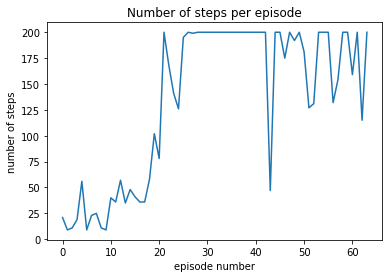

In [104]:
plt.plot(logs.episodes_steps)
plt.title("Number of steps per episode")
plt.xlabel("episode number")
plt.ylabel("number of steps")
plt.show;

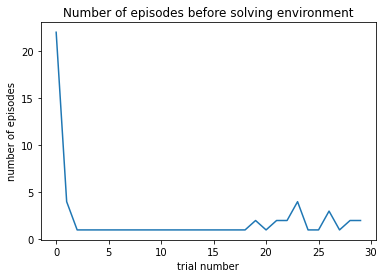

In [105]:
plt.plot(logs.episodes_before_solve)
plt.title("Number of episodes before solving environment")
plt.xlabel("trial number")
plt.ylabel("number of episodes")
plt.show;

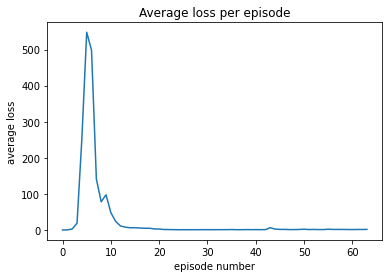

In [106]:
plt.plot(np.divide(logs.episodes_loss,logs.episodes_steps))
plt.title("Average loss per episode")
plt.xlabel("episode number")
plt.ylabel("average loss")
plt.show;